In [1846]:
%matplotlib inline
import pandas as pd
from datetime import datetime
from matplotlib import pyplot
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Dropout
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler


In [1847]:
def date_parser(x):
    return datetime.strptime(x, '%Y-%m-%d')

In [3097]:
data = pd.read_csv('../Data/EmotionMetrics/poms_scratch_2019-2020v2.csv', index_col=0,warn_bad_lines=True,error_bad_lines=False, parse_dates=['Date'], date_parser=date_parser)
# data = data.set_index('Date')
data = data.dropna()
data.head(5)

,Tension,Depression,Anger,Fatigue,Confusion,Vigour,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,,,,,,
2018-12-31,0.199039,0.519098,0.516361,0.559851,0.312904,0.463503,0.042584,0.026881,0.077328,0.102260,0.102260,0.096301
2019-01-02,0.208180,0.441180,0.539493,0.288889,0.713221,0.252131,0.026911,0.040647,0.046759,0.105255,0.105255,0.111857
2019-01-03,0.345099,0.489385,0.439936,0.508735,0.490458,0.267814,0.046275,0.000000,0.000000,0.000000,0.000000,0.160639
2019-01-04,0.252721,0.603827,0.163539,0.526752,0.456524,0.480547,0.000000,0.058678,0.041333,0.119116,0.119116,0.147230
2019-01-07,0.365727,0.490065,0.518240,0.406486,0.480487,0.367560,0.095245,0.087670,0.106863,0.134775,0.134775,0.117858


In [3504]:
# COLUMNS = ['Tension','Depression','Close']
# COLUMNS = ['Tension','Close']
# COLUMNS = ['Tension','Depression','Anger', 'Fatigue', 'Confusion', 'Vigour', 'Close']
COLUMNS = ['Close']

NUM_LAGS = 4
INPUT_DAYS = 1

In [3505]:
df = data[COLUMNS]

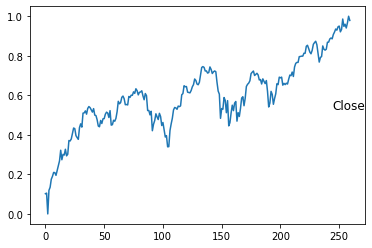

In [3506]:
# load dataset
values = df.values
# specify columns to plot
groups = range(len(df.columns))
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
#     pyplot.figure(figsize=(5,10))
    pyplot.title(df.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [3507]:
def series_to_supervised(raw_df, label_col, input_days=2, lag_days=3):
    values = raw_df.values    
    encoder = LabelEncoder()
    values[:,-1] = encoder.fit_transform(values[:,-1])
    values = values.astype('float32')
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    
    column_names = raw_df.columns

    scaled_df = pd.DataFrame(scaled, columns=column_names)
    cols, names = [],[]
    for i in range(input_days-1, -1, -1):
        cols.append(scaled_df.shift(i))
        if(i == 0):
            names += [(f'{col_name}(t)') for col_name in column_names]
        else:
            names += [(f'{col_name}(t-{i})') for col_name in column_names]    

            
    cols.append(scaled_df[label_col].shift(-lag_days))
    names.append(f'{label_col}(t+{lag_days})')
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    agg.dropna(inplace=True)
    return agg
        

In [3508]:
reframed = series_to_supervised(df, 'Close', input_days=INPUT_DAYS, lag_days=NUM_LAGS)
reframed = reframed[NUM_LAGS:]

In [3509]:
def train_test_split(df, train_ratio=0.4):
#     msk = np.random.rand(len(df)) < train_ratio
    train = df[:int(train_ratio * len(df))]
    test = df[int(train_ratio * len(df)):]
    train_X = train[train.columns[:-1]].to_numpy()
    train_y = train[train.columns[-1]].to_numpy()

    test_X = test[test.columns[:-1]].to_numpy()
    test_y = test[test.columns[-1]].to_numpy()

    # display(train_X, train_y, test_X, test_y)

    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    # print(train_X.shape, test_X.shape)
    return train_X, train_y, test_X, test_y

In [3510]:
train_X, train_y, test_X, test_y = train_test_split(reframed, train_ratio=.6)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(151, 1, 1) (151,) (101, 1, 1) (101,)


In [3511]:
# design network
model = keras.Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=25, shuffle=False, validation_data=(test_X, test_y))

Epoch 1/100
7/7 [==============================] - 3s 127ms/step - loss: 0.2589 - val_loss: 0.6652
Epoch 2/100
7/7 [==============================] - 0s 12ms/step - loss: 0.2239 - val_loss: 0.6167
Epoch 3/100
7/7 [==============================] - 0s 12ms/step - loss: 0.1938 - val_loss: 0.5679
Epoch 4/100
7/7 [==============================] - 0s 11ms/step - loss: 0.1657 - val_loss: 0.5187
Epoch 5/100
7/7 [==============================] - 0s 11ms/step - loss: 0.1477 - val_loss: 0.4699
Epoch 6/100
7/7 [==============================] - 0s 11ms/step - loss: 0.1392 - val_loss: 0.4229
Epoch 7/100
7/7 [==============================] - 0s 12ms/step - loss: 0.1326 - val_loss: 0.3793
Epoch 8/100
7/7 [==============================] - 0s 11ms/step - loss: 0.1294 - val_loss: 0.3376
Epoch 9/100
7/7 [==============================] - 0s 11ms/step - loss: 0.1263 - val_loss: 0.2998
Epoch 10/100
7/7 [==============================] - 0s 16ms/step - loss: 0.1338 - val_loss: 0.2703
Epoch 11/100
7/7 [

Epoch 84/100
7/7 [==============================] - 0s 12ms/step - loss: 0.0773 - val_loss: 0.0848
Epoch 85/100
7/7 [==============================] - 0s 12ms/step - loss: 0.0756 - val_loss: 0.0782
Epoch 86/100
7/7 [==============================] - 0s 17ms/step - loss: 0.0805 - val_loss: 0.0739
Epoch 87/100
7/7 [==============================] - 0s 12ms/step - loss: 0.0775 - val_loss: 0.0767
Epoch 88/100
7/7 [==============================] - 0s 10ms/step - loss: 0.0806 - val_loss: 0.0777
Epoch 89/100
7/7 [==============================] - 0s 11ms/step - loss: 0.0757 - val_loss: 0.0804
Epoch 90/100
7/7 [==============================] - 0s 12ms/step - loss: 0.0781 - val_loss: 0.0781
Epoch 91/100
7/7 [==============================] - 0s 11ms/step - loss: 0.0797 - val_loss: 0.0798
Epoch 92/100
7/7 [==============================] - 0s 12ms/step - loss: 0.0810 - val_loss: 0.0890
Epoch 93/100
7/7 [==============================] - 0s 13ms/step - loss: 0.0772 - val_loss: 0.0975
Epoch 94/1

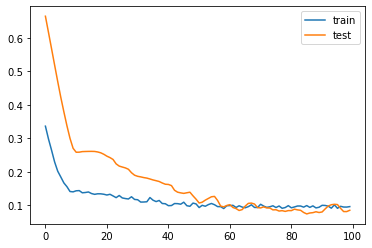

In [3512]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

pyplot.show()

In [3513]:
from numpy import concatenate

# make a prediction
yhat = model.predict(test_X)

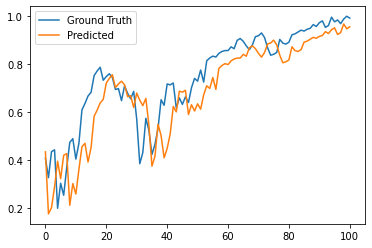

In [3514]:
pyplot.plot(test_y, label='Ground Truth')
pyplot.plot(yhat, label='Predicted')

pyplot.legend()

In [3515]:
r2_score(yhat, test_y)

0.7129816567676142

## Test on new data

In [3516]:
test_data = pd.read_csv('../Data/EmotionMetrics/poms_scratch_2017-2018.csv', index_col=0,warn_bad_lines=True,error_bad_lines=False, parse_dates=['Date'], date_parser=date_parser)

In [3517]:
test_df = test_data[COLUMNS]
test_reframed = series_to_supervised(test_df, 'Close', input_days=INPUT_DAYS, lag_days=NUM_LAGS)
reframed.head()

,Close(t),Close(t+4)
4,0.015504,0.031008
5,0.019380,0.027132
6,0.023256,0.038760
7,0.034884,0.042636
8,0.031008,0.046512


In [3500]:
_, _, _test_X, _test_y = train_test_split(test_reframed,0)

In [3501]:
_yhat = model.predict(_test_X)

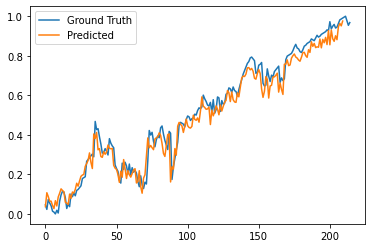

In [3519]:
pyplot.plot(_test_y, label='Ground Truth')
pyplot.plot(_yhat, label='Predicted')
pyplot.legend()

In [3503]:
r2_score(_yhat, _test_y)

0.8979491504372614